# One shot learning siamese network for omniglot dataset
### Implementation of the following paper
Siamese Neural Networks for One-shot Image Recognition (Gregory et.al)

## Requirements


1.   Pytorch >= 0.4.0
2.   Python 3.5+

## Deep Siamese Networks for Image Verification 
Siamese  nets  were  first  introduced  in  the  early  1990s  by
Bromley and LeCun to solve signature verification as an
image matching problem. A siamese neural network consists of twin networks which accept distinct inputs but are joined by an energy function at the top. This function computes some metric between the highest-level feature representation on each side. Also, the network is symmetric, so that whenever we present two distinct images to the twin networks, the top conjoining layer will compute the same metric as if we were to we present the same two images but to the opposite twins.

The aim is to  first  learn  a  neural  network  that  can  discriminate between  the  class-identity  of  image  pairs,  which  is  the standard verification task for image recognition.  The verification model learns to identify input pairs according to the probability  that  they  belong  to  the  same  class  or  different classes.  This model can then be used to evaluate new images, exactly one per novel class, in a pairwise manner against the test image.  The pairing with the highest score according to the verification network is then awarded the highest  probability  for  the  one-shot  task.   If  the  features learned by the verification model are sufficient to confirm or deny the identity of characters from one set of alphabets,  then they ought to be sufficient for other alphabets, provided that the model has been exposed to a variety of alphabets to encourage variance amongst the learned features.
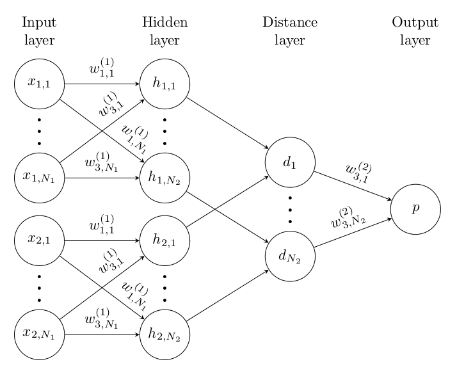

### Step1- Setting up the workspace
Download the Omniglot dataset and unzip it in the workspace (in this case workspace is 'Omniglot'). Save the data in two folders 'images_background' and 'images_evaluation' respectively. 

### Step2- Installing frameworks and impoting libraries
Importing all the libraries, dependencies and the framework required using the following commands
!pip install torch torchvision
!pip install Pillow==4.0.0
!pip install image


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from numpy.random import choice as npc
import numpy as np
import time
import random
import torchvision.datasets as dset
from PIL import Image
import pickle
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch.nn as nn
import torch.nn.functional as F

## Omniglot dataset

The Omniglot data set was collected by Brenden Lake and
his collaborators at MIT via Amazon’s Mechanical Turk to
produce a standard benchmark for learning from few examples in the handwritten character recognition domain.
Omniglot contains examples from 50 alphabets ranging from well established international languages like Latin and Korean to lesser known local dialects. The number of letters in each alphabet varies considerably
from  about  15  to  upwards  of  40  characters
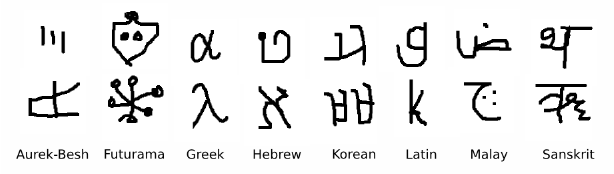

### Step3- Preprocessing training dataset
Creating a class for loading training dataset which samples two random images and gives it a label =1.0 if they belong to the same class or label= 0.0 if they belong to different class. Each pair is given a specific index.

In [2]:
class OmniglotTrain(Dataset):

    def __init__(self, dataset, transform=None):
        super(OmniglotTrain, self).__init__()
        np.random.seed(0)
        self.dataset = dataset
        self.transform = transform
        self.img1 = None

    def __len__(self):
        return  21000000

    def __getitem__(self, index):
        image1 = random.choice(self.dataset.imgs)
        # get image from same class
        label = None
        if index % 2 == 1:
            label = 1.0
            while True:
                image2 = random.choice(self.dataset.imgs)
                if image1[1] == image2[1]:
                    break
        # get image from different class
        else:
            label = 0.0
            while True:
                image2 = random.choice(self.dataset.imgs)
                if image1[1] != image2[1]:
                    break
        image1 = Image.open(image1[0])
        image2 = Image.open(image2[0])
        image1 = image1.convert('L')
        image2 = image2.convert('L')

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32))

### Step4 - Preprocessing testing data
Creating a class for loading test dataset. This class samples two random images from the test dataset and gives it a specific index. As it is a 20 way classification, one in 20 pairs belongs to the same class. Each class gets one example.

In [3]:
class OmniglotTest(Dataset):

    def __init__(self, dataset, transform=None, times=200, way=20):
        np.random.seed(1)
        super(OmniglotTest, self).__init__()
        self.dataset = dataset
        self.transform = transform
        self.times = times
        self.way = way

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        # generate image pair from same class
        if idx == 0:
            self.img1 = random.choice(self.dataset.imgs)
            while True:
                img2 = random.choice(self.dataset.imgs)
                if self.img1[1] == img2[1]:
                    break
        # generate image pair from different class
        else:
            while True:
                img2 = random.choice(self.dataset.imgs)
                if self.img1[1] != img2[1]:
                    break

        img1 = Image.open(self.img1[0])
        img2 = Image.open(img2[0])
        img1 = img1.convert('L')
        img2 = img2.convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2


### Step 5- Model

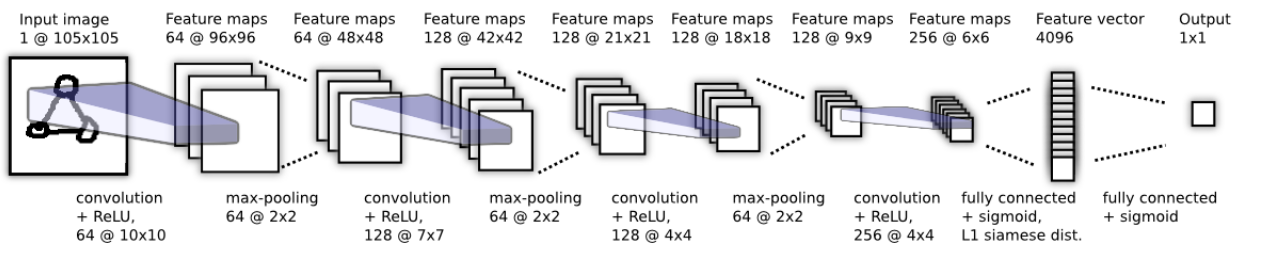

The model consists of a sequence of convolutional layers, each of which uses a single channel with filters of varying
size and a fixed stride of 1.  The number of convolutional filters is specified as a multiple of 16 to optimize performance.   The network applies a ReLU activation function to  the  output  feature  maps,  optionally  followed  by  max-pooling with a filter size and stride of 2.

The units in the final convolutional layer are flattened into a  single  vector.   This  convolutional  layer  is  followed  by a  fully-connected  layer,  and  then  one  more  layer  computing the induced distance metric between each siamese twin,  which  is  given  to  a  single  sigmoidal  output  unit.


In [4]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #  return self.sigmoid(out)
        return out

### Step 6- GPU check
check whether CUDA is working

In [5]:
cuda = torch.cuda.is_available()
print("Cuda: " + str(cuda))          #Checking if CUDA is available

Cuda: True


### Step 7- Affine distortions
Augmenting the training set with small affine distortions.  For each
image  pair
x1, x2,  we  generated  a  pair  of  affine  transformations T1, T2 to  yield x′1= T1(x1), x′2=T2(x2), where T1, T2 are determined  stochastically  by  a  multi-dimensional uniform distribution. 
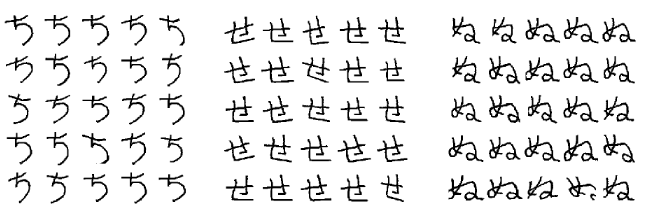

In [6]:
data_transforms = transforms.Compose([
    transforms.RandomAffine(15),
    transforms.ToTensor()
])

### Step 8- Setting up the path for loading training and testing dataset

In [7]:
train_path = 'Omniglot/images_background'
test_path = 'Omniglot/images_evaluation'
train_dataset = dset.ImageFolder(root=train_path)
test_dataset = dset.ImageFolder(root=test_path)

### Step 9- Loading the data and creating pairs for training and testing with Affine distortions

In [8]:
way = 20
times = 400

dataSet = OmniglotTrain(train_dataset, transform=data_transforms)
testSet = OmniglotTest(test_dataset, transform=transforms.ToTensor(), times = times, way = way)
testLoader = DataLoader(testSet, batch_size=way, shuffle=False, num_workers=16)

dataLoader = DataLoader(dataSet, batch_size=128,\
                        shuffle=False, num_workers=16)

### Step 10- Loss function

A regularized cross-entropy objective on our binary classifier

In [9]:
loss_fn = torch.nn.BCEWithLogitsLoss(size_average=True)
learning_rate = 0.0006
net = Siamese()
train_loss = []
net.train()
if cuda:
    net.cuda()

/home/ameya/.local/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


### Step 11- Optimizer
Used a standarised Adam optimizer

In [10]:
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate )
optimizer.zero_grad()

### Step 12- Setting up the parameters

In [11]:
show_every = 10
save_every = 100
test_every = 100
train_loss = []
loss_val = 0
max_iter = 90000
losses=[]
batch_ids= []

### Step 13- Training and testing after every 100 batch size

In [12]:
for batch_id, (img1, img2, label) in enumerate(dataLoader, 1):
    if batch_id > max_iter:
        break
    batch_start = time.time()
    if cuda:
        img1, img2, label = Variable(img1.cuda()), Variable(img2.cuda()), Variable(label.cuda())
    else:
        img1, img2, label = Variable(img1), Variable(img2), Variable(label)
    optimizer.zero_grad()
    output = net.forward(img1, img2)
    loss = loss_fn(output, label)
    loss_val += loss.item()
    loss.backward()
    optimizer.step()
    if batch_id % show_every == 0 :
        print('[%d]\tloss:\t%.5f\tTook\t%.2f s'%(batch_id, loss_val/show_every, (time.time() - batch_start)*show_every))
        batch_ids.append(float(batch_id))
        losses.append(loss_val/show_every)
        loss_val = 0
    if batch_id % save_every == 0:
        torch.save(net.state_dict(), 'Omniglot/model/model-batch-%d.pth'%(batch_id+1,))
    if batch_id % test_every == 0:
        right, error = 0, 0
        for _, (test1, test2) in enumerate(testLoader, 1):
            if cuda:
                test1, test2 = test1.cuda(), test2.cuda()
            test1, test2 = Variable(test1), Variable(test2)
            output = net.forward(test1, test2).data.cpu().numpy()
            pred = np.argmax(output)
            if pred == 0:
                right += 1
            else: error += 1
        print('*'*70)
        print('[%d]\tright:\t%d\terror:\t%d\tprecision:\t%f'%(batch_id, right, error, right*1.0/(right+error)))
        print('*'*70)
    train_loss.append(loss_val)
#  learning_rate = learning_rate * 0.95

with open('train_loss', 'wb') as f:
    pickle.dump(train_loss, f)

[10]	loss:	0.69155	Took	2.64 s
[20]	loss:	0.68879	Took	2.53 s
[30]	loss:	0.68501	Took	2.53 s
[40]	loss:	0.68374	Took	2.44 s
[50]	loss:	0.68685	Took	2.49 s
[60]	loss:	0.67780	Took	2.59 s
[70]	loss:	0.68062	Took	2.60 s
[80]	loss:	0.67514	Took	2.52 s
[90]	loss:	0.66638	Took	2.52 s
[100]	loss:	0.67969	Took	2.64 s
**********************************************************************
[100]	right:	41	error:	359	precision:	0.102500
**********************************************************************
[110]	loss:	0.66776	Took	2.50 s
[120]	loss:	0.67249	Took	2.60 s
[130]	loss:	0.66525	Took	2.49 s
[140]	loss:	0.68079	Took	2.49 s
[150]	loss:	0.67727	Took	2.51 s
[160]	loss:	0.66247	Took	2.53 s
[170]	loss:	0.66151	Took	2.51 s
[180]	loss:	0.66310	Took	2.59 s
[190]	loss:	0.67606	Took	2.51 s
[200]	loss:	0.66738	Took	2.47 s
**********************************************************************
[200]	right:	30	error:	370	precision:	0.075000
**************************************************************

[1610]	loss:	0.45049	Took	2.41 s
[1620]	loss:	0.44639	Took	2.43 s
[1630]	loss:	0.44606	Took	2.43 s
[1640]	loss:	0.47431	Took	2.43 s
[1650]	loss:	0.47372	Took	2.43 s
[1660]	loss:	0.43845	Took	2.42 s
[1670]	loss:	0.46507	Took	2.42 s
[1680]	loss:	0.42491	Took	2.43 s
[1690]	loss:	0.46635	Took	2.42 s
[1700]	loss:	0.46862	Took	2.42 s
**********************************************************************
[1700]	right:	52	error:	348	precision:	0.130000
**********************************************************************
[1710]	loss:	0.47933	Took	2.42 s
[1720]	loss:	0.46787	Took	2.42 s
[1730]	loss:	0.45971	Took	2.45 s
[1740]	loss:	0.46178	Took	2.42 s
[1750]	loss:	0.42459	Took	2.41 s
[1760]	loss:	0.46209	Took	2.42 s
[1770]	loss:	0.44507	Took	2.42 s
[1780]	loss:	0.45365	Took	2.44 s
[1790]	loss:	0.46333	Took	2.42 s
[1800]	loss:	0.45098	Took	2.42 s
**********************************************************************
[1800]	right:	56	error:	344	precision:	0.140000
*******************************

[3210]	loss:	0.32592	Took	2.43 s
[3220]	loss:	0.32762	Took	2.43 s
[3230]	loss:	0.32850	Took	2.44 s
[3240]	loss:	0.31986	Took	2.44 s
[3250]	loss:	0.32599	Took	2.43 s
[3260]	loss:	0.31702	Took	2.42 s
[3270]	loss:	0.31626	Took	2.41 s
[3280]	loss:	0.32527	Took	2.45 s
[3290]	loss:	0.33957	Took	2.43 s
[3300]	loss:	0.31241	Took	2.43 s
**********************************************************************
[3300]	right:	60	error:	340	precision:	0.150000
**********************************************************************
[3310]	loss:	0.33575	Took	2.43 s
[3320]	loss:	0.29922	Took	2.44 s
[3330]	loss:	0.31271	Took	2.43 s
[3340]	loss:	0.33297	Took	2.43 s
[3350]	loss:	0.31227	Took	2.42 s
[3360]	loss:	0.33819	Took	2.42 s
[3370]	loss:	0.30810	Took	2.42 s
[3380]	loss:	0.29528	Took	2.44 s
[3390]	loss:	0.30544	Took	2.45 s
[3400]	loss:	0.28570	Took	2.42 s
**********************************************************************
[3400]	right:	64	error:	336	precision:	0.160000
*******************************

[4810]	loss:	0.25323	Took	2.42 s
[4820]	loss:	0.26955	Took	2.43 s
[4830]	loss:	0.25283	Took	2.41 s
[4840]	loss:	0.22858	Took	2.45 s
[4850]	loss:	0.22853	Took	2.44 s
[4860]	loss:	0.23624	Took	2.42 s
[4870]	loss:	0.26976	Took	2.42 s
[4880]	loss:	0.26077	Took	2.41 s
[4890]	loss:	0.26005	Took	2.45 s
[4900]	loss:	0.25258	Took	2.44 s
**********************************************************************
[4900]	right:	60	error:	340	precision:	0.150000
**********************************************************************
[4910]	loss:	0.25368	Took	2.41 s
[4920]	loss:	0.26953	Took	2.42 s
[4930]	loss:	0.26073	Took	2.42 s
[4940]	loss:	0.24508	Took	2.45 s
[4950]	loss:	0.23596	Took	2.45 s
[4960]	loss:	0.24151	Took	2.43 s
[4970]	loss:	0.22655	Took	2.42 s
[4980]	loss:	0.24164	Took	2.42 s
[4990]	loss:	0.22466	Took	2.42 s
[5000]	loss:	0.23797	Took	2.42 s
**********************************************************************
[5000]	right:	61	error:	339	precision:	0.152500
*******************************

[6410]	loss:	0.20652	Took	2.42 s
[6420]	loss:	0.19399	Took	2.43 s
[6430]	loss:	0.19285	Took	2.44 s
[6440]	loss:	0.19133	Took	2.43 s
[6450]	loss:	0.21329	Took	2.44 s
[6460]	loss:	0.19752	Took	2.44 s
[6470]	loss:	0.20213	Took	2.43 s
[6480]	loss:	0.22698	Took	2.43 s
[6490]	loss:	0.18683	Took	2.42 s
[6500]	loss:	0.20546	Took	2.42 s
**********************************************************************
[6500]	right:	61	error:	339	precision:	0.152500
**********************************************************************
[6510]	loss:	0.18298	Took	2.42 s
[6520]	loss:	0.20514	Took	2.45 s
[6530]	loss:	0.18966	Took	2.42 s
[6540]	loss:	0.21251	Took	2.42 s
[6550]	loss:	0.21701	Took	2.43 s
[6560]	loss:	0.21146	Took	2.44 s
[6570]	loss:	0.19731	Took	2.43 s
[6580]	loss:	0.19923	Took	2.43 s
[6590]	loss:	0.19785	Took	2.41 s
[6600]	loss:	0.18888	Took	2.45 s
**********************************************************************
[6600]	right:	54	error:	346	precision:	0.135000
*******************************

[8010]	loss:	0.16106	Took	2.42 s
[8020]	loss:	0.17592	Took	2.44 s
[8030]	loss:	0.15700	Took	2.42 s
[8040]	loss:	0.18293	Took	2.42 s
[8050]	loss:	0.16125	Took	2.42 s
[8060]	loss:	0.17469	Took	2.43 s
[8070]	loss:	0.16476	Took	2.42 s
[8080]	loss:	0.15389	Took	2.43 s
[8090]	loss:	0.15507	Took	2.42 s
[8100]	loss:	0.13124	Took	2.42 s
**********************************************************************
[8100]	right:	53	error:	347	precision:	0.132500
**********************************************************************
[8110]	loss:	0.15040	Took	2.42 s
[8120]	loss:	0.16264	Took	2.42 s
[8130]	loss:	0.19569	Took	2.44 s
[8140]	loss:	0.15295	Took	2.42 s
[8150]	loss:	0.18765	Took	2.42 s
[8160]	loss:	0.17357	Took	2.42 s
[8170]	loss:	0.16630	Took	2.42 s
[8180]	loss:	0.17203	Took	2.42 s
[8190]	loss:	0.18295	Took	2.42 s
[8200]	loss:	0.18567	Took	2.42 s
**********************************************************************
[8200]	right:	70	error:	330	precision:	0.175000
*******************************

[9610]	loss:	0.14701	Took	2.41 s
[9620]	loss:	0.14230	Took	2.43 s
[9630]	loss:	0.13629	Took	2.43 s
[9640]	loss:	0.15342	Took	2.42 s
[9650]	loss:	0.12188	Took	2.42 s
[9660]	loss:	0.15760	Took	2.42 s
[9670]	loss:	0.15340	Took	2.44 s
[9680]	loss:	0.14556	Took	2.42 s
[9690]	loss:	0.13756	Took	2.42 s
[9700]	loss:	0.15700	Took	2.43 s
**********************************************************************
[9700]	right:	57	error:	343	precision:	0.142500
**********************************************************************
[9710]	loss:	0.14029	Took	2.42 s
[9720]	loss:	0.15257	Took	2.42 s
[9730]	loss:	0.15507	Took	2.42 s
[9740]	loss:	0.14835	Took	2.43 s
[9750]	loss:	0.15633	Took	2.42 s
[9760]	loss:	0.14612	Took	2.43 s
[9770]	loss:	0.16665	Took	2.43 s
[9780]	loss:	0.16795	Took	2.42 s
[9790]	loss:	0.16771	Took	2.42 s
[9800]	loss:	0.14910	Took	2.42 s
**********************************************************************
[9800]	right:	63	error:	337	precision:	0.157500
*******************************

[11190]	loss:	0.14204	Took	2.43 s
[11200]	loss:	0.13795	Took	2.43 s
**********************************************************************
[11200]	right:	53	error:	347	precision:	0.132500
**********************************************************************
[11210]	loss:	0.13919	Took	2.50 s
[11220]	loss:	0.11803	Took	2.43 s
[11230]	loss:	0.14057	Took	2.42 s
[11240]	loss:	0.11690	Took	2.43 s
[11250]	loss:	0.13340	Took	2.42 s
[11260]	loss:	0.12989	Took	2.42 s
[11270]	loss:	0.14946	Took	2.44 s
[11280]	loss:	0.13516	Took	2.42 s
[11290]	loss:	0.11396	Took	2.42 s
[11300]	loss:	0.10335	Took	2.42 s
**********************************************************************
[11300]	right:	56	error:	344	precision:	0.140000
**********************************************************************
[11310]	loss:	0.12428	Took	2.42 s
[11320]	loss:	0.13237	Took	2.43 s
[11330]	loss:	0.13802	Took	2.42 s
[11340]	loss:	0.11892	Took	2.42 s
[11350]	loss:	0.13830	Took	2.43 s
[11360]	loss:	0.13043	Took	2.43 s
[11370

[12710]	loss:	0.11019	Took	2.42 s
[12720]	loss:	0.09505	Took	2.42 s
[12730]	loss:	0.11451	Took	2.44 s
[12740]	loss:	0.12372	Took	2.42 s
[12750]	loss:	0.11775	Took	2.42 s
[12760]	loss:	0.13668	Took	2.44 s
[12770]	loss:	0.11187	Took	2.41 s
[12780]	loss:	0.12738	Took	2.47 s
[12790]	loss:	0.12405	Took	2.43 s
[12800]	loss:	0.13587	Took	2.43 s
**********************************************************************
[12800]	right:	63	error:	337	precision:	0.157500
**********************************************************************
[12810]	loss:	0.13377	Took	2.43 s
[12820]	loss:	0.10922	Took	2.42 s
[12830]	loss:	0.09632	Took	2.42 s
[12840]	loss:	0.11243	Took	2.41 s
[12850]	loss:	0.13029	Took	2.42 s
[12860]	loss:	0.11799	Took	2.42 s
[12870]	loss:	0.10238	Took	2.42 s
[12880]	loss:	0.09723	Took	2.43 s
[12890]	loss:	0.13386	Took	2.43 s
[12900]	loss:	0.13511	Took	2.42 s
**********************************************************************
[12900]	right:	57	error:	343	precision:	0.142500
*********

[14280]	loss:	0.10946	Took	2.43 s
[14290]	loss:	0.09898	Took	2.42 s
[14300]	loss:	0.11650	Took	2.41 s
**********************************************************************
[14300]	right:	46	error:	354	precision:	0.115000
**********************************************************************
[14310]	loss:	0.10700	Took	2.43 s
[14320]	loss:	0.11517	Took	2.42 s
[14330]	loss:	0.10130	Took	2.42 s
[14340]	loss:	0.12141	Took	2.42 s
[14350]	loss:	0.10748	Took	2.42 s
[14360]	loss:	0.10133	Took	2.42 s
[14370]	loss:	0.11993	Took	2.42 s
[14380]	loss:	0.09500	Took	2.43 s
[14390]	loss:	0.11869	Took	2.43 s
[14400]	loss:	0.09741	Took	2.43 s
**********************************************************************
[14400]	right:	69	error:	331	precision:	0.172500
**********************************************************************
[14410]	loss:	0.08989	Took	2.42 s
[14420]	loss:	0.12186	Took	2.42 s
[14430]	loss:	0.10394	Took	2.42 s
[14440]	loss:	0.10352	Took	2.43 s
[14450]	loss:	0.11806	Took	2.43 s
[14460

[15810]	loss:	0.10804	Took	2.41 s
[15820]	loss:	0.07971	Took	2.46 s
[15830]	loss:	0.09806	Took	2.42 s
[15840]	loss:	0.10887	Took	2.42 s
[15850]	loss:	0.08224	Took	2.42 s
[15860]	loss:	0.10706	Took	2.42 s
[15870]	loss:	0.12722	Took	2.42 s
[15880]	loss:	0.09487	Took	2.43 s
[15890]	loss:	0.14100	Took	2.43 s
[15900]	loss:	0.09238	Took	2.43 s
**********************************************************************
[15900]	right:	50	error:	350	precision:	0.125000
**********************************************************************
[15910]	loss:	0.10123	Took	2.41 s
[15920]	loss:	0.09225	Took	2.42 s
[15930]	loss:	0.08627	Took	2.43 s
[15940]	loss:	0.10489	Took	2.42 s
[15950]	loss:	0.11243	Took	2.43 s
[15960]	loss:	0.09476	Took	2.42 s
[15970]	loss:	0.09100	Took	2.41 s
[15980]	loss:	0.09160	Took	2.42 s
[15990]	loss:	0.10827	Took	2.41 s
[16000]	loss:	0.09086	Took	2.42 s
**********************************************************************
[16000]	right:	68	error:	332	precision:	0.170000
*********

[17380]	loss:	0.10136	Took	2.42 s
[17390]	loss:	0.09409	Took	2.41 s
[17400]	loss:	0.09139	Took	2.42 s
**********************************************************************
[17400]	right:	61	error:	339	precision:	0.152500
**********************************************************************
[17410]	loss:	0.10076	Took	2.42 s
[17420]	loss:	0.08965	Took	2.43 s
[17430]	loss:	0.10268	Took	2.42 s
[17440]	loss:	0.09190	Took	2.43 s
[17450]	loss:	0.06710	Took	2.42 s
[17460]	loss:	0.10871	Took	2.42 s
[17470]	loss:	0.07160	Took	2.43 s
[17480]	loss:	0.08413	Took	2.42 s
[17490]	loss:	0.09814	Took	2.44 s
[17500]	loss:	0.09088	Took	2.41 s
**********************************************************************
[17500]	right:	63	error:	337	precision:	0.157500
**********************************************************************
[17510]	loss:	0.08749	Took	2.43 s
[17520]	loss:	0.08252	Took	2.42 s
[17530]	loss:	0.07622	Took	2.42 s
[17540]	loss:	0.10004	Took	2.43 s
[17550]	loss:	0.08895	Took	2.42 s
[17560

[18910]	loss:	0.11786	Took	2.41 s
[18920]	loss:	0.07989	Took	2.42 s
[18930]	loss:	0.09578	Took	2.43 s
[18940]	loss:	0.07711	Took	2.41 s
[18950]	loss:	0.10075	Took	2.42 s
[18960]	loss:	0.08149	Took	2.42 s
[18970]	loss:	0.08739	Took	2.42 s
[18980]	loss:	0.07325	Took	2.42 s
[18990]	loss:	0.08158	Took	2.42 s
[19000]	loss:	0.09067	Took	2.43 s
**********************************************************************
[19000]	right:	53	error:	347	precision:	0.132500
**********************************************************************
[19010]	loss:	0.08288	Took	2.41 s
[19020]	loss:	0.08342	Took	2.44 s
[19030]	loss:	0.06168	Took	2.41 s
[19040]	loss:	0.08881	Took	2.43 s
[19050]	loss:	0.07786	Took	2.42 s
[19060]	loss:	0.07578	Took	2.46 s
[19070]	loss:	0.07224	Took	2.44 s
[19080]	loss:	0.07716	Took	2.42 s
[19090]	loss:	0.10832	Took	2.42 s
[19100]	loss:	0.09485	Took	2.42 s
**********************************************************************
[19100]	right:	64	error:	336	precision:	0.160000
*********

[20480]	loss:	0.08551	Took	2.41 s
[20490]	loss:	0.08507	Took	2.43 s
[20500]	loss:	0.08566	Took	2.41 s
**********************************************************************
[20500]	right:	61	error:	339	precision:	0.152500
**********************************************************************
[20510]	loss:	0.07535	Took	2.42 s
[20520]	loss:	0.07370	Took	2.41 s
[20530]	loss:	0.07350	Took	2.43 s
[20540]	loss:	0.06441	Took	2.43 s
[20550]	loss:	0.08052	Took	2.40 s
[20560]	loss:	0.08289	Took	2.42 s
[20570]	loss:	0.08076	Took	2.41 s
[20580]	loss:	0.08395	Took	2.42 s
[20590]	loss:	0.09021	Took	2.41 s
[20600]	loss:	0.07458	Took	2.42 s
**********************************************************************
[20600]	right:	49	error:	351	precision:	0.122500
**********************************************************************
[20610]	loss:	0.08855	Took	2.43 s
[20620]	loss:	0.08274	Took	2.43 s
[20630]	loss:	0.09679	Took	2.42 s
[20640]	loss:	0.07346	Took	2.41 s
[20650]	loss:	0.10026	Took	2.43 s
[20660

[22010]	loss:	0.09486	Took	2.41 s
[22020]	loss:	0.07794	Took	2.42 s
[22030]	loss:	0.08626	Took	2.43 s
[22040]	loss:	0.07686	Took	2.42 s
[22050]	loss:	0.08693	Took	2.43 s
[22060]	loss:	0.08500	Took	2.44 s
[22070]	loss:	0.09112	Took	2.43 s
[22080]	loss:	0.08828	Took	2.43 s
[22090]	loss:	0.09039	Took	2.41 s
[22100]	loss:	0.06698	Took	2.42 s
**********************************************************************
[22100]	right:	61	error:	339	precision:	0.152500
**********************************************************************
[22110]	loss:	0.09204	Took	2.42 s
[22120]	loss:	0.08617	Took	2.42 s
[22130]	loss:	0.05990	Took	2.42 s
[22140]	loss:	0.07793	Took	2.43 s
[22150]	loss:	0.08772	Took	2.43 s
[22160]	loss:	0.06960	Took	2.43 s
[22170]	loss:	0.07278	Took	2.42 s
[22180]	loss:	0.09058	Took	2.42 s
[22190]	loss:	0.06630	Took	2.42 s
[22200]	loss:	0.06421	Took	2.44 s
**********************************************************************
[22200]	right:	59	error:	341	precision:	0.147500
*********

[23580]	loss:	0.10404	Took	2.39 s
[23590]	loss:	0.08000	Took	2.43 s
[23600]	loss:	0.08391	Took	2.41 s
**********************************************************************
[23600]	right:	60	error:	340	precision:	0.150000
**********************************************************************
[23610]	loss:	0.07010	Took	2.42 s
[23620]	loss:	0.06693	Took	2.43 s
[23630]	loss:	0.08276	Took	2.42 s
[23640]	loss:	0.08646	Took	2.41 s
[23650]	loss:	0.06836	Took	2.41 s
[23660]	loss:	0.10441	Took	2.42 s
[23670]	loss:	0.09076	Took	2.42 s
[23680]	loss:	0.09047	Took	2.41 s
[23690]	loss:	0.10378	Took	2.42 s
[23700]	loss:	0.09041	Took	2.42 s
**********************************************************************
[23700]	right:	54	error:	346	precision:	0.135000
**********************************************************************
[23710]	loss:	0.07725	Took	2.42 s
[23720]	loss:	0.07197	Took	2.41 s
[23730]	loss:	0.07396	Took	2.41 s
[23740]	loss:	0.10704	Took	2.41 s
[23750]	loss:	0.08752	Took	2.42 s
[23760

[25110]	loss:	0.06594	Took	2.43 s
[25120]	loss:	0.07954	Took	2.41 s
[25130]	loss:	0.05772	Took	2.41 s
[25140]	loss:	0.08121	Took	2.41 s
[25150]	loss:	0.07568	Took	2.41 s
[25160]	loss:	0.07519	Took	2.42 s
[25170]	loss:	0.08435	Took	2.42 s
[25180]	loss:	0.07718	Took	2.42 s
[25190]	loss:	0.07541	Took	2.41 s
[25200]	loss:	0.06664	Took	2.42 s
**********************************************************************
[25200]	right:	50	error:	350	precision:	0.125000
**********************************************************************
[25210]	loss:	0.07623	Took	2.42 s
[25220]	loss:	0.06344	Took	2.43 s
[25230]	loss:	0.07646	Took	2.42 s
[25240]	loss:	0.06743	Took	2.41 s
[25250]	loss:	0.07167	Took	2.41 s
[25260]	loss:	0.06771	Took	2.42 s
[25270]	loss:	0.06975	Took	2.41 s
[25280]	loss:	0.05529	Took	2.42 s
[25290]	loss:	0.06638	Took	2.42 s
[25300]	loss:	0.05620	Took	2.42 s
**********************************************************************
[25300]	right:	70	error:	330	precision:	0.175000
*********

[26680]	loss:	0.05939	Took	2.42 s
[26690]	loss:	0.06829	Took	2.42 s
[26700]	loss:	0.08260	Took	2.43 s
**********************************************************************
[26700]	right:	57	error:	343	precision:	0.142500
**********************************************************************
[26710]	loss:	0.06849	Took	2.41 s
[26720]	loss:	0.06138	Took	2.42 s
[26730]	loss:	0.04568	Took	2.41 s
[26740]	loss:	0.05762	Took	2.41 s
[26750]	loss:	0.06930	Took	2.42 s
[26760]	loss:	0.07515	Took	2.42 s
[26770]	loss:	0.05804	Took	2.41 s
[26780]	loss:	0.07994	Took	2.41 s
[26790]	loss:	0.06523	Took	2.43 s
[26800]	loss:	0.07498	Took	2.41 s
**********************************************************************
[26800]	right:	57	error:	343	precision:	0.142500
**********************************************************************
[26810]	loss:	0.07287	Took	2.41 s
[26820]	loss:	0.07844	Took	2.42 s
[26830]	loss:	0.05769	Took	2.41 s
[26840]	loss:	0.07213	Took	2.42 s
[26850]	loss:	0.07499	Took	2.42 s
[26860

[28210]	loss:	0.06005	Took	2.41 s
[28220]	loss:	0.06286	Took	2.42 s
[28230]	loss:	0.06470	Took	2.42 s
[28240]	loss:	0.06035	Took	2.42 s
[28250]	loss:	0.07644	Took	2.41 s
[28260]	loss:	0.06181	Took	2.42 s
[28270]	loss:	0.05447	Took	2.42 s
[28280]	loss:	0.04176	Took	2.42 s
[28290]	loss:	0.05679	Took	2.42 s
[28300]	loss:	0.05599	Took	2.43 s
**********************************************************************
[28300]	right:	61	error:	339	precision:	0.152500
**********************************************************************
[28310]	loss:	0.05918	Took	2.41 s
[28320]	loss:	0.06514	Took	2.41 s
[28330]	loss:	0.06751	Took	2.42 s
[28340]	loss:	0.05580	Took	2.43 s
[28350]	loss:	0.05587	Took	2.42 s
[28360]	loss:	0.06967	Took	2.42 s
[28370]	loss:	0.06710	Took	2.42 s
[28380]	loss:	0.05298	Took	2.42 s
[28390]	loss:	0.06659	Took	2.43 s
[28400]	loss:	0.05953	Took	2.42 s
**********************************************************************
[28400]	right:	53	error:	347	precision:	0.132500
*********

[29780]	loss:	0.04836	Took	2.42 s
[29790]	loss:	0.05547	Took	2.42 s
[29800]	loss:	0.07161	Took	2.42 s
**********************************************************************
[29800]	right:	54	error:	346	precision:	0.135000
**********************************************************************
[29810]	loss:	0.05412	Took	2.41 s
[29820]	loss:	0.06171	Took	2.41 s
[29830]	loss:	0.06648	Took	2.41 s
[29840]	loss:	0.06037	Took	2.41 s
[29850]	loss:	0.07341	Took	2.42 s
[29860]	loss:	0.06457	Took	2.41 s
[29870]	loss:	0.07181	Took	2.44 s
[29880]	loss:	0.07539	Took	2.42 s
[29890]	loss:	0.05740	Took	2.41 s
[29900]	loss:	0.06490	Took	2.44 s
**********************************************************************
[29900]	right:	57	error:	343	precision:	0.142500
**********************************************************************
[29910]	loss:	0.07020	Took	2.42 s
[29920]	loss:	0.07806	Took	2.43 s
[29930]	loss:	0.06960	Took	2.42 s
[29940]	loss:	0.05263	Took	2.40 s
[29950]	loss:	0.06956	Took	2.41 s
[29960

[31310]	loss:	0.07486	Took	2.44 s
[31320]	loss:	0.07334	Took	2.42 s
[31330]	loss:	0.07480	Took	2.42 s
[31340]	loss:	0.06519	Took	2.42 s
[31350]	loss:	0.05746	Took	2.42 s
[31360]	loss:	0.06511	Took	2.41 s
[31370]	loss:	0.05995	Took	2.42 s
[31380]	loss:	0.06915	Took	2.41 s
[31390]	loss:	0.06039	Took	2.42 s
[31400]	loss:	0.06368	Took	2.41 s
**********************************************************************
[31400]	right:	61	error:	339	precision:	0.152500
**********************************************************************
[31410]	loss:	0.06392	Took	2.42 s
[31420]	loss:	0.05792	Took	2.41 s
[31430]	loss:	0.04639	Took	2.42 s
[31440]	loss:	0.06422	Took	2.42 s
[31450]	loss:	0.05416	Took	2.41 s
[31460]	loss:	0.07294	Took	2.41 s
[31470]	loss:	0.06245	Took	2.43 s
[31480]	loss:	0.05322	Took	2.42 s
[31490]	loss:	0.06866	Took	2.41 s
[31500]	loss:	0.05823	Took	2.42 s
**********************************************************************
[31500]	right:	38	error:	362	precision:	0.095000
*********

[32880]	loss:	0.06394	Took	2.42 s
[32890]	loss:	0.05344	Took	2.42 s
[32900]	loss:	0.04694	Took	2.42 s
**********************************************************************
[32900]	right:	50	error:	350	precision:	0.125000
**********************************************************************
[32910]	loss:	0.05870	Took	2.42 s
[32920]	loss:	0.06090	Took	2.42 s
[32930]	loss:	0.05859	Took	2.42 s
[32940]	loss:	0.05601	Took	2.42 s
[32950]	loss:	0.05939	Took	2.42 s
[32960]	loss:	0.05701	Took	2.41 s
[32970]	loss:	0.06655	Took	2.42 s
[32980]	loss:	0.06170	Took	2.42 s
[32990]	loss:	0.05853	Took	2.43 s
[33000]	loss:	0.05809	Took	2.45 s
**********************************************************************
[33000]	right:	47	error:	353	precision:	0.117500
**********************************************************************
[33010]	loss:	0.06701	Took	2.42 s
[33020]	loss:	0.05446	Took	2.43 s
[33030]	loss:	0.04570	Took	2.42 s
[33040]	loss:	0.05924	Took	2.41 s
[33050]	loss:	0.05201	Took	2.42 s
[33060

[34410]	loss:	0.04194	Took	2.43 s
[34420]	loss:	0.04318	Took	2.43 s
[34430]	loss:	0.05937	Took	2.42 s
[34440]	loss:	0.05154	Took	2.41 s
[34450]	loss:	0.07145	Took	2.40 s
[34460]	loss:	0.05550	Took	2.41 s
[34470]	loss:	0.07325	Took	2.42 s
[34480]	loss:	0.05256	Took	2.42 s
[34490]	loss:	0.04525	Took	2.42 s
[34500]	loss:	0.03917	Took	2.42 s
**********************************************************************
[34500]	right:	55	error:	345	precision:	0.137500
**********************************************************************
[34510]	loss:	0.05772	Took	2.41 s
[34520]	loss:	0.06288	Took	2.41 s
[34530]	loss:	0.04692	Took	2.42 s
[34540]	loss:	0.06393	Took	2.41 s
[34550]	loss:	0.06489	Took	2.42 s
[34560]	loss:	0.05479	Took	2.41 s
[34570]	loss:	0.06102	Took	2.42 s
[34580]	loss:	0.07318	Took	2.43 s
[34590]	loss:	0.06810	Took	2.42 s
[34600]	loss:	0.07328	Took	2.42 s
**********************************************************************
[34600]	right:	54	error:	346	precision:	0.135000
*********

[35980]	loss:	0.06226	Took	2.42 s
[35990]	loss:	0.05818	Took	2.42 s
[36000]	loss:	0.05472	Took	2.42 s
**********************************************************************
[36000]	right:	60	error:	340	precision:	0.150000
**********************************************************************
[36010]	loss:	0.06817	Took	2.42 s
[36020]	loss:	0.06046	Took	2.41 s
[36030]	loss:	0.05337	Took	2.41 s
[36040]	loss:	0.07265	Took	2.41 s
[36050]	loss:	0.05715	Took	2.43 s
[36060]	loss:	0.05707	Took	2.43 s
[36070]	loss:	0.06024	Took	2.42 s
[36080]	loss:	0.04934	Took	2.42 s
[36090]	loss:	0.06509	Took	2.42 s
[36100]	loss:	0.04158	Took	2.41 s
**********************************************************************
[36100]	right:	60	error:	340	precision:	0.150000
**********************************************************************
[36110]	loss:	0.06229	Took	2.41 s
[36120]	loss:	0.07394	Took	2.41 s
[36130]	loss:	0.05088	Took	2.42 s
[36140]	loss:	0.07021	Took	2.41 s
[36150]	loss:	0.06112	Took	2.40 s
[36160

[37510]	loss:	0.05838	Took	2.42 s
[37520]	loss:	0.05273	Took	2.42 s
[37530]	loss:	0.05766	Took	2.42 s
[37540]	loss:	0.06163	Took	2.43 s
[37550]	loss:	0.06652	Took	2.42 s
[37560]	loss:	0.08191	Took	2.42 s
[37570]	loss:	0.05557	Took	2.42 s
[37580]	loss:	0.08127	Took	2.43 s
[37590]	loss:	0.06692	Took	2.41 s
[37600]	loss:	0.06073	Took	2.42 s
**********************************************************************
[37600]	right:	49	error:	351	precision:	0.122500
**********************************************************************
[37610]	loss:	0.06612	Took	2.42 s
[37620]	loss:	0.06450	Took	2.42 s
[37630]	loss:	0.04863	Took	2.41 s
[37640]	loss:	0.07024	Took	2.41 s
[37650]	loss:	0.06738	Took	2.41 s
[37660]	loss:	0.06947	Took	2.42 s
[37670]	loss:	0.05747	Took	2.43 s
[37680]	loss:	0.05371	Took	2.43 s
[37690]	loss:	0.04475	Took	2.43 s
[37700]	loss:	0.06593	Took	2.42 s
**********************************************************************
[37700]	right:	54	error:	346	precision:	0.135000
*********

[39080]	loss:	0.06088	Took	2.42 s
[39090]	loss:	0.04839	Took	2.41 s
[39100]	loss:	0.04541	Took	2.42 s
**********************************************************************
[39100]	right:	55	error:	345	precision:	0.137500
**********************************************************************
[39110]	loss:	0.05940	Took	2.42 s
[39120]	loss:	0.06822	Took	2.42 s
[39130]	loss:	0.06280	Took	2.41 s
[39140]	loss:	0.07616	Took	2.41 s
[39150]	loss:	0.05369	Took	2.42 s
[39160]	loss:	0.05631	Took	2.43 s
[39170]	loss:	0.05467	Took	2.42 s
[39180]	loss:	0.05391	Took	2.42 s
[39190]	loss:	0.05875	Took	2.42 s
[39200]	loss:	0.05246	Took	2.42 s
**********************************************************************
[39200]	right:	46	error:	354	precision:	0.115000
**********************************************************************
[39210]	loss:	0.07181	Took	2.42 s
[39220]	loss:	0.08788	Took	2.41 s
[39230]	loss:	0.03454	Took	2.42 s
[39240]	loss:	0.04893	Took	2.42 s
[39250]	loss:	0.06128	Took	2.42 s
[39260

[40610]	loss:	0.06428	Took	2.40 s
[40620]	loss:	0.06492	Took	2.42 s
[40630]	loss:	0.05187	Took	2.41 s
[40640]	loss:	0.06526	Took	2.41 s
[40650]	loss:	0.05737	Took	2.42 s
[40660]	loss:	0.05265	Took	2.43 s
[40670]	loss:	0.05145	Took	2.42 s
[40680]	loss:	0.06530	Took	2.42 s
[40690]	loss:	0.05352	Took	2.42 s
[40700]	loss:	0.06672	Took	2.41 s
**********************************************************************
[40700]	right:	44	error:	356	precision:	0.110000
**********************************************************************
[40710]	loss:	0.06167	Took	2.42 s
[40720]	loss:	0.04422	Took	2.42 s
[40730]	loss:	0.06151	Took	2.41 s
[40740]	loss:	0.06555	Took	2.42 s
[40750]	loss:	0.07701	Took	2.41 s
[40760]	loss:	0.05178	Took	2.41 s
[40770]	loss:	0.06818	Took	2.42 s
[40780]	loss:	0.08036	Took	2.42 s
[40790]	loss:	0.07586	Took	2.42 s
[40800]	loss:	0.05717	Took	2.42 s
**********************************************************************
[40800]	right:	41	error:	359	precision:	0.102500
*********

[42180]	loss:	0.09360	Took	2.42 s
[42190]	loss:	0.07221	Took	2.42 s
[42200]	loss:	0.05652	Took	2.44 s
**********************************************************************
[42200]	right:	60	error:	340	precision:	0.150000
**********************************************************************
[42210]	loss:	0.05733	Took	2.42 s
[42220]	loss:	0.06916	Took	2.43 s
[42230]	loss:	0.05750	Took	2.42 s
[42240]	loss:	0.06186	Took	2.42 s
[42250]	loss:	0.04225	Took	2.41 s
[42260]	loss:	0.06197	Took	2.42 s
[42270]	loss:	0.06597	Took	2.41 s
[42280]	loss:	0.06252	Took	2.41 s
[42290]	loss:	0.07494	Took	2.41 s
[42300]	loss:	0.06213	Took	2.41 s
**********************************************************************
[42300]	right:	67	error:	333	precision:	0.167500
**********************************************************************
[42310]	loss:	0.05976	Took	2.42 s
[42320]	loss:	0.05508	Took	2.42 s
[42330]	loss:	0.07239	Took	2.42 s
[42340]	loss:	0.05037	Took	2.42 s
[42350]	loss:	0.04504	Took	2.43 s
[42360

[43710]	loss:	0.05085	Took	2.41 s
[43720]	loss:	0.06951	Took	2.42 s
[43730]	loss:	0.04610	Took	2.42 s
[43740]	loss:	0.05692	Took	2.41 s
[43750]	loss:	0.06717	Took	2.40 s
[43760]	loss:	0.05301	Took	2.41 s
[43770]	loss:	0.08537	Took	2.42 s
[43780]	loss:	0.05909	Took	2.43 s
[43790]	loss:	0.07639	Took	2.42 s
[43800]	loss:	0.06404	Took	2.42 s
**********************************************************************
[43800]	right:	70	error:	330	precision:	0.175000
**********************************************************************
[43810]	loss:	0.07105	Took	2.41 s
[43820]	loss:	0.06939	Took	2.41 s
[43830]	loss:	0.06077	Took	2.41 s
[43840]	loss:	0.05391	Took	2.43 s
[43850]	loss:	0.06807	Took	2.41 s
[43860]	loss:	0.07792	Took	2.42 s
[43870]	loss:	0.06492	Took	2.43 s
[43880]	loss:	0.06755	Took	2.41 s
[43890]	loss:	0.06912	Took	2.42 s
[43900]	loss:	0.04958	Took	2.42 s
**********************************************************************
[43900]	right:	40	error:	360	precision:	0.100000
*********

[45280]	loss:	0.06827	Took	2.41 s
[45290]	loss:	0.06241	Took	2.41 s
[45300]	loss:	0.07587	Took	2.41 s
**********************************************************************
[45300]	right:	59	error:	341	precision:	0.147500
**********************************************************************
[45310]	loss:	0.07008	Took	2.42 s
[45320]	loss:	0.06185	Took	2.42 s
[45330]	loss:	0.08351	Took	2.41 s
[45340]	loss:	0.07162	Took	2.42 s
[45350]	loss:	0.04961	Took	2.40 s
[45360]	loss:	0.06157	Took	2.40 s
[45370]	loss:	0.06429	Took	2.41 s
[45380]	loss:	0.07741	Took	2.42 s
[45390]	loss:	0.05129	Took	2.42 s
[45400]	loss:	0.07216	Took	2.41 s
**********************************************************************
[45400]	right:	61	error:	339	precision:	0.152500
**********************************************************************
[45410]	loss:	0.06185	Took	2.42 s
[45420]	loss:	0.07169	Took	2.41 s
[45430]	loss:	0.07079	Took	2.43 s
[45440]	loss:	0.05936	Took	2.42 s
[45450]	loss:	0.08207	Took	2.41 s
[45460

[46810]	loss:	0.08650	Took	2.42 s
[46820]	loss:	0.07224	Took	2.41 s
[46830]	loss:	0.05371	Took	2.41 s
[46840]	loss:	0.05936	Took	2.41 s
[46850]	loss:	0.06507	Took	2.42 s
[46860]	loss:	0.05245	Took	2.41 s
[46870]	loss:	0.05658	Took	2.42 s
[46880]	loss:	0.07430	Took	2.41 s
[46890]	loss:	0.05712	Took	2.43 s
[46900]	loss:	0.06955	Took	2.43 s
**********************************************************************
[46900]	right:	55	error:	345	precision:	0.137500
**********************************************************************
[46910]	loss:	0.05193	Took	2.42 s
[46920]	loss:	0.06161	Took	2.41 s
[46930]	loss:	0.06882	Took	2.42 s
[46940]	loss:	0.07614	Took	2.43 s
[46950]	loss:	0.06154	Took	2.41 s
[46960]	loss:	0.05548	Took	2.42 s
[46970]	loss:	0.05739	Took	2.42 s
[46980]	loss:	0.07352	Took	2.43 s
[46990]	loss:	0.05855	Took	2.42 s
[47000]	loss:	0.05843	Took	2.42 s
**********************************************************************
[47000]	right:	45	error:	355	precision:	0.112500
*********

[48380]	loss:	0.04443	Took	2.42 s
[48390]	loss:	0.07010	Took	2.41 s
[48400]	loss:	0.05139	Took	2.42 s
**********************************************************************
[48400]	right:	64	error:	336	precision:	0.160000
**********************************************************************
[48410]	loss:	0.05716	Took	2.42 s
[48420]	loss:	0.06825	Took	2.41 s
[48430]	loss:	0.06502	Took	2.41 s
[48440]	loss:	0.05173	Took	2.41 s
[48450]	loss:	0.07459	Took	2.42 s
[48460]	loss:	0.07377	Took	2.42 s
[48470]	loss:	0.05911	Took	2.42 s
[48480]	loss:	0.06709	Took	2.41 s
[48490]	loss:	0.07313	Took	2.42 s
[48500]	loss:	0.08575	Took	2.42 s
**********************************************************************
[48500]	right:	58	error:	342	precision:	0.145000
**********************************************************************
[48510]	loss:	0.05787	Took	2.42 s
[48520]	loss:	0.05945	Took	2.42 s
[48530]	loss:	0.05288	Took	2.43 s
[48540]	loss:	0.07290	Took	2.42 s
[48550]	loss:	0.04937	Took	2.43 s
[48560

[49910]	loss:	0.05769	Took	2.42 s
[49920]	loss:	0.05696	Took	2.42 s
[49930]	loss:	0.06607	Took	2.42 s
[49940]	loss:	0.05860	Took	2.42 s
[49950]	loss:	0.07101	Took	2.42 s
[49960]	loss:	0.05672	Took	2.40 s
[49970]	loss:	0.05617	Took	2.41 s
[49980]	loss:	0.04854	Took	2.44 s
[49990]	loss:	0.05594	Took	2.42 s
[50000]	loss:	0.07800	Took	2.41 s
**********************************************************************
[50000]	right:	49	error:	351	precision:	0.122500
**********************************************************************
[50010]	loss:	0.06243	Took	2.42 s
[50020]	loss:	0.06824	Took	2.42 s
[50030]	loss:	0.06652	Took	2.42 s
[50040]	loss:	0.04777	Took	2.42 s
[50050]	loss:	0.05223	Took	2.42 s
[50060]	loss:	0.06863	Took	2.42 s
[50070]	loss:	0.05994	Took	2.44 s
[50080]	loss:	0.06490	Took	2.41 s
[50090]	loss:	0.05831	Took	2.42 s
[50100]	loss:	0.05217	Took	2.42 s
**********************************************************************
[50100]	right:	51	error:	349	precision:	0.127500
*********

[51480]	loss:	0.07579	Took	2.42 s
[51490]	loss:	0.06802	Took	2.41 s
[51500]	loss:	0.07431	Took	2.43 s
**********************************************************************
[51500]	right:	62	error:	338	precision:	0.155000
**********************************************************************
[51510]	loss:	0.06830	Took	2.41 s
[51520]	loss:	0.06014	Took	2.43 s
[51530]	loss:	0.07924	Took	2.42 s
[51540]	loss:	0.06596	Took	2.43 s
[51550]	loss:	0.08591	Took	2.42 s
[51560]	loss:	0.05883	Took	2.42 s
[51570]	loss:	0.08392	Took	2.42 s
[51580]	loss:	0.06707	Took	2.41 s
[51590]	loss:	0.06687	Took	2.42 s
[51600]	loss:	0.07146	Took	2.41 s
**********************************************************************
[51600]	right:	60	error:	340	precision:	0.150000
**********************************************************************
[51610]	loss:	0.06546	Took	2.41 s
[51620]	loss:	0.07185	Took	2.42 s
[51630]	loss:	0.06923	Took	2.41 s
[51640]	loss:	0.07449	Took	2.41 s
[51650]	loss:	0.08416	Took	2.42 s
[51660

[53010]	loss:	0.09411	Took	2.43 s
[53020]	loss:	0.07295	Took	2.42 s
[53030]	loss:	0.04725	Took	2.41 s
[53040]	loss:	0.08418	Took	2.41 s
[53050]	loss:	0.07964	Took	2.42 s
[53060]	loss:	0.06806	Took	2.42 s
[53070]	loss:	0.06446	Took	2.41 s
[53080]	loss:	0.07800	Took	2.42 s
[53090]	loss:	0.08365	Took	2.43 s
[53100]	loss:	0.08064	Took	2.41 s
**********************************************************************
[53100]	right:	64	error:	336	precision:	0.160000
**********************************************************************
[53110]	loss:	0.06484	Took	2.42 s
[53120]	loss:	0.07151	Took	2.42 s
[53130]	loss:	0.05080	Took	2.40 s
[53140]	loss:	0.07683	Took	2.42 s
[53150]	loss:	0.06542	Took	2.42 s
[53160]	loss:	0.08479	Took	2.43 s
[53170]	loss:	0.06862	Took	2.42 s
[53180]	loss:	0.07051	Took	2.41 s
[53190]	loss:	0.07020	Took	2.42 s
[53200]	loss:	0.06090	Took	2.42 s
**********************************************************************
[53200]	right:	45	error:	355	precision:	0.112500
*********

[54580]	loss:	0.04864	Took	2.41 s
[54590]	loss:	0.08630	Took	2.41 s
[54600]	loss:	0.06395	Took	2.42 s
**********************************************************************
[54600]	right:	55	error:	345	precision:	0.137500
**********************************************************************
[54610]	loss:	0.06399	Took	2.41 s
[54620]	loss:	0.07531	Took	2.42 s
[54630]	loss:	0.06278	Took	2.42 s
[54640]	loss:	0.07672	Took	2.41 s
[54650]	loss:	0.08980	Took	2.43 s
[54660]	loss:	0.09270	Took	2.41 s
[54670]	loss:	0.08225	Took	2.43 s
[54680]	loss:	0.07092	Took	2.43 s
[54690]	loss:	0.06323	Took	2.42 s
[54700]	loss:	0.05746	Took	2.42 s
**********************************************************************
[54700]	right:	51	error:	349	precision:	0.127500
**********************************************************************
[54710]	loss:	0.07382	Took	2.42 s
[54720]	loss:	0.07089	Took	2.41 s
[54730]	loss:	0.05407	Took	2.41 s
[54740]	loss:	0.07788	Took	2.40 s
[54750]	loss:	0.08025	Took	2.43 s
[54760

[56110]	loss:	0.06853	Took	2.42 s
[56120]	loss:	0.06819	Took	2.41 s
[56130]	loss:	0.07795	Took	2.43 s
[56140]	loss:	0.05821	Took	2.42 s
[56150]	loss:	0.06237	Took	2.42 s
[56160]	loss:	0.06847	Took	2.42 s
[56170]	loss:	0.05704	Took	2.41 s
[56180]	loss:	0.05771	Took	2.42 s
[56190]	loss:	0.05536	Took	2.42 s
[56200]	loss:	0.06726	Took	2.43 s
**********************************************************************
[56200]	right:	47	error:	353	precision:	0.117500
**********************************************************************
[56210]	loss:	0.07714	Took	2.46 s
[56220]	loss:	0.08019	Took	2.41 s
[56230]	loss:	0.07717	Took	2.42 s
[56240]	loss:	0.07937	Took	2.41 s
[56250]	loss:	0.06828	Took	2.43 s
[56260]	loss:	0.07959	Took	2.42 s
[56270]	loss:	0.06562	Took	2.42 s
[56280]	loss:	0.04936	Took	2.42 s
[56290]	loss:	0.06967	Took	2.42 s
[56300]	loss:	0.09482	Took	2.42 s
**********************************************************************
[56300]	right:	53	error:	347	precision:	0.132500
*********

[57680]	loss:	0.06586	Took	2.43 s
[57690]	loss:	0.08951	Took	2.42 s
[57700]	loss:	0.07513	Took	2.42 s
**********************************************************************
[57700]	right:	45	error:	355	precision:	0.112500
**********************************************************************
[57710]	loss:	0.08924	Took	2.41 s
[57720]	loss:	0.06962	Took	2.43 s
[57730]	loss:	0.07631	Took	2.40 s
[57740]	loss:	0.07248	Took	2.42 s
[57750]	loss:	0.08781	Took	2.41 s
[57760]	loss:	0.06550	Took	2.41 s
[57770]	loss:	0.08144	Took	2.41 s
[57780]	loss:	0.09330	Took	2.41 s
[57790]	loss:	0.06668	Took	2.42 s
[57800]	loss:	0.09932	Took	2.41 s
**********************************************************************
[57800]	right:	41	error:	359	precision:	0.102500
**********************************************************************
[57810]	loss:	0.08197	Took	2.42 s
[57820]	loss:	0.08265	Took	2.43 s
[57830]	loss:	0.05751	Took	2.41 s
[57840]	loss:	0.09285	Took	2.40 s
[57850]	loss:	0.06230	Took	2.42 s
[57860

[59210]	loss:	0.06873	Took	2.41 s
[59220]	loss:	0.07650	Took	2.43 s
[59230]	loss:	0.07142	Took	2.42 s
[59240]	loss:	0.06863	Took	2.42 s
[59250]	loss:	0.09247	Took	2.41 s
[59260]	loss:	0.07206	Took	2.42 s
[59270]	loss:	0.07399	Took	2.41 s
[59280]	loss:	0.09069	Took	2.41 s
[59290]	loss:	0.08129	Took	2.42 s
[59300]	loss:	0.08586	Took	2.42 s
**********************************************************************
[59300]	right:	43	error:	357	precision:	0.107500
**********************************************************************
[59310]	loss:	0.06738	Took	2.42 s
[59320]	loss:	0.07136	Took	2.47 s
[59330]	loss:	0.06670	Took	2.42 s
[59340]	loss:	0.05407	Took	2.42 s
[59350]	loss:	0.08070	Took	2.41 s
[59360]	loss:	0.09352	Took	2.41 s
[59370]	loss:	0.08079	Took	2.42 s
[59380]	loss:	0.04965	Took	2.42 s
[59390]	loss:	0.07847	Took	2.43 s
[59400]	loss:	0.06398	Took	2.41 s
**********************************************************************
[59400]	right:	43	error:	357	precision:	0.107500
*********

[60780]	loss:	0.05942	Took	2.42 s
[60790]	loss:	0.10613	Took	2.42 s
[60800]	loss:	0.07938	Took	2.42 s
**********************************************************************
[60800]	right:	50	error:	350	precision:	0.125000
**********************************************************************
[60810]	loss:	0.09871	Took	2.42 s
[60820]	loss:	0.07874	Took	2.42 s
[60830]	loss:	0.09202	Took	2.42 s
[60840]	loss:	0.06037	Took	2.41 s
[60850]	loss:	0.06501	Took	2.43 s
[60860]	loss:	0.06133	Took	2.42 s
[60870]	loss:	0.08889	Took	2.43 s
[60880]	loss:	0.06999	Took	2.41 s
[60890]	loss:	0.07183	Took	2.42 s
[60900]	loss:	0.06488	Took	2.42 s
**********************************************************************
[60900]	right:	51	error:	349	precision:	0.127500
**********************************************************************
[60910]	loss:	0.07247	Took	2.43 s
[60920]	loss:	0.08833	Took	2.42 s
[60930]	loss:	0.09471	Took	2.41 s
[60940]	loss:	0.07511	Took	2.42 s
[60950]	loss:	0.08904	Took	2.41 s
[60960

[62310]	loss:	0.05927	Took	2.42 s
[62320]	loss:	0.06725	Took	2.42 s
[62330]	loss:	0.07858	Took	2.42 s
[62340]	loss:	0.08809	Took	2.43 s
[62350]	loss:	0.08330	Took	2.42 s
[62360]	loss:	0.08914	Took	2.42 s
[62370]	loss:	0.06405	Took	2.41 s
[62380]	loss:	0.07002	Took	2.43 s
[62390]	loss:	0.07616	Took	2.44 s
[62400]	loss:	0.08981	Took	2.42 s
**********************************************************************
[62400]	right:	53	error:	347	precision:	0.132500
**********************************************************************
[62410]	loss:	0.05123	Took	2.42 s
[62420]	loss:	0.07184	Took	2.42 s
[62430]	loss:	0.07460	Took	2.42 s
[62440]	loss:	0.06281	Took	2.41 s
[62450]	loss:	0.09529	Took	2.42 s
[62460]	loss:	0.06032	Took	2.43 s
[62470]	loss:	0.06955	Took	2.42 s
[62480]	loss:	0.08262	Took	2.43 s
[62490]	loss:	0.07161	Took	2.43 s
[62500]	loss:	0.06404	Took	2.47 s
**********************************************************************
[62500]	right:	58	error:	342	precision:	0.145000
*********

[63880]	loss:	0.08401	Took	2.43 s
[63890]	loss:	0.08728	Took	2.41 s
[63900]	loss:	0.08667	Took	2.42 s
**********************************************************************
[63900]	right:	52	error:	348	precision:	0.130000
**********************************************************************
[63910]	loss:	0.07099	Took	2.41 s
[63920]	loss:	0.08079	Took	2.41 s
[63930]	loss:	0.06309	Took	2.40 s
[63940]	loss:	0.08338	Took	2.41 s
[63950]	loss:	0.06369	Took	2.41 s
[63960]	loss:	0.06782	Took	2.42 s
[63970]	loss:	0.08408	Took	2.41 s
[63980]	loss:	0.08399	Took	2.42 s
[63990]	loss:	0.08651	Took	2.41 s
[64000]	loss:	0.08924	Took	2.43 s
**********************************************************************
[64000]	right:	54	error:	346	precision:	0.135000
**********************************************************************
[64010]	loss:	0.08979	Took	2.41 s
[64020]	loss:	0.07966	Took	2.42 s
[64030]	loss:	0.09316	Took	2.41 s
[64040]	loss:	0.09282	Took	2.42 s
[64050]	loss:	0.09706	Took	2.44 s
[64060

[65410]	loss:	0.10739	Took	2.41 s
[65420]	loss:	0.08903	Took	2.42 s
[65430]	loss:	0.09216	Took	2.42 s
[65440]	loss:	0.08957	Took	2.43 s
[65450]	loss:	0.06318	Took	2.42 s
[65460]	loss:	0.08998	Took	2.42 s
[65470]	loss:	0.06844	Took	2.41 s
[65480]	loss:	0.08335	Took	2.43 s
[65490]	loss:	0.07566	Took	2.42 s
[65500]	loss:	0.06863	Took	2.40 s
**********************************************************************
[65500]	right:	49	error:	351	precision:	0.122500
**********************************************************************
[65510]	loss:	0.08610	Took	2.41 s
[65520]	loss:	0.08268	Took	2.41 s
[65530]	loss:	0.18261	Took	2.41 s
[65540]	loss:	0.24207	Took	2.42 s
[65550]	loss:	0.11686	Took	2.43 s
[65560]	loss:	0.09848	Took	2.41 s
[65570]	loss:	0.12267	Took	2.42 s
[65580]	loss:	0.09443	Took	2.42 s
[65590]	loss:	0.08810	Took	2.41 s
[65600]	loss:	0.11162	Took	2.42 s
**********************************************************************
[65600]	right:	53	error:	347	precision:	0.132500
*********

[66980]	loss:	0.09799	Took	2.41 s
[66990]	loss:	0.08452	Took	2.42 s
[67000]	loss:	0.08043	Took	2.43 s
**********************************************************************
[67000]	right:	53	error:	347	precision:	0.132500
**********************************************************************
[67010]	loss:	0.08782	Took	2.42 s
[67020]	loss:	0.09097	Took	2.41 s
[67030]	loss:	0.08926	Took	2.42 s
[67040]	loss:	0.08783	Took	2.42 s
[67050]	loss:	0.09982	Took	2.41 s
[67060]	loss:	0.09594	Took	2.42 s
[67070]	loss:	0.09964	Took	2.42 s
[67080]	loss:	0.08989	Took	2.42 s
[67090]	loss:	0.07814	Took	2.41 s
[67100]	loss:	0.08758	Took	2.42 s
**********************************************************************
[67100]	right:	45	error:	355	precision:	0.112500
**********************************************************************
[67110]	loss:	0.11942	Took	2.42 s
[67120]	loss:	0.07416	Took	2.42 s
[67130]	loss:	0.08066	Took	2.41 s
[67140]	loss:	0.07771	Took	2.41 s
[67150]	loss:	0.10237	Took	2.42 s
[67160

[68510]	loss:	0.07202	Took	2.41 s
[68520]	loss:	0.10363	Took	2.42 s
[68530]	loss:	0.07136	Took	2.41 s
[68540]	loss:	0.09335	Took	2.42 s
[68550]	loss:	0.08061	Took	2.42 s
[68560]	loss:	0.10979	Took	2.42 s
[68570]	loss:	0.06316	Took	2.41 s
[68580]	loss:	0.11569	Took	2.42 s
[68590]	loss:	0.09653	Took	2.42 s
[68600]	loss:	0.06994	Took	2.43 s
**********************************************************************
[68600]	right:	62	error:	338	precision:	0.155000
**********************************************************************
[68610]	loss:	0.08444	Took	2.42 s
[68620]	loss:	0.08623	Took	2.41 s
[68630]	loss:	0.09233	Took	2.43 s
[68640]	loss:	0.07950	Took	2.41 s
[68650]	loss:	0.08371	Took	2.42 s
[68660]	loss:	0.08852	Took	2.41 s
[68670]	loss:	0.08165	Took	2.42 s
[68680]	loss:	0.09146	Took	2.42 s
[68690]	loss:	0.08248	Took	2.41 s
[68700]	loss:	0.09375	Took	2.40 s
**********************************************************************
[68700]	right:	56	error:	344	precision:	0.140000
*********

[70080]	loss:	0.08744	Took	2.41 s
[70090]	loss:	0.08073	Took	2.41 s
[70100]	loss:	0.09375	Took	2.44 s
**********************************************************************
[70100]	right:	53	error:	347	precision:	0.132500
**********************************************************************
[70110]	loss:	0.09568	Took	2.41 s
[70120]	loss:	0.09243	Took	2.41 s
[70130]	loss:	0.08793	Took	2.42 s
[70140]	loss:	0.09686	Took	2.44 s
[70150]	loss:	0.10670	Took	2.42 s
[70160]	loss:	0.07566	Took	2.42 s
[70170]	loss:	0.11191	Took	2.41 s
[70180]	loss:	0.09147	Took	2.41 s
[70190]	loss:	0.10111	Took	2.42 s
[70200]	loss:	0.12052	Took	2.42 s
**********************************************************************
[70200]	right:	41	error:	359	precision:	0.102500
**********************************************************************
[70210]	loss:	0.08963	Took	2.42 s
[70220]	loss:	0.08926	Took	2.42 s
[70230]	loss:	0.08292	Took	2.41 s
[70240]	loss:	0.07128	Took	2.41 s
[70250]	loss:	0.07877	Took	2.41 s
[70260

[71610]	loss:	0.08325	Took	2.41 s
[71620]	loss:	0.09143	Took	2.43 s
[71630]	loss:	0.09821	Took	2.42 s
[71640]	loss:	0.10190	Took	2.42 s
[71650]	loss:	0.08945	Took	2.42 s
[71660]	loss:	0.09861	Took	2.41 s
[71670]	loss:	0.09950	Took	2.42 s
[71680]	loss:	0.08779	Took	2.42 s
[71690]	loss:	0.08761	Took	2.43 s
[71700]	loss:	0.09291	Took	2.42 s
**********************************************************************
[71700]	right:	43	error:	357	precision:	0.107500
**********************************************************************
[71710]	loss:	0.08223	Took	2.42 s
[71720]	loss:	0.08125	Took	2.42 s
[71730]	loss:	0.12399	Took	2.42 s
[71740]	loss:	0.10260	Took	2.41 s
[71750]	loss:	0.08032	Took	2.41 s
[71760]	loss:	0.10346	Took	2.41 s
[71770]	loss:	0.08585	Took	2.41 s
[71780]	loss:	0.09750	Took	2.41 s
[71790]	loss:	0.10240	Took	2.41 s
[71800]	loss:	0.11931	Took	2.41 s
**********************************************************************
[71800]	right:	58	error:	342	precision:	0.145000
*********

[73180]	loss:	0.09190	Took	2.41 s
[73190]	loss:	0.12335	Took	2.43 s
[73200]	loss:	0.08731	Took	2.41 s
**********************************************************************
[73200]	right:	51	error:	349	precision:	0.127500
**********************************************************************
[73210]	loss:	0.09467	Took	2.42 s
[73220]	loss:	0.09640	Took	2.40 s
[73230]	loss:	0.11499	Took	2.41 s
[73240]	loss:	0.10824	Took	2.41 s
[73250]	loss:	0.09070	Took	2.41 s
[73260]	loss:	0.11242	Took	2.42 s
[73270]	loss:	0.08500	Took	2.42 s
[73280]	loss:	0.08652	Took	2.41 s
[73290]	loss:	0.12236	Took	2.41 s
[73300]	loss:	0.11812	Took	2.42 s
**********************************************************************
[73300]	right:	57	error:	343	precision:	0.142500
**********************************************************************
[73310]	loss:	0.13363	Took	2.43 s
[73320]	loss:	0.12244	Took	2.41 s
[73330]	loss:	0.13676	Took	2.42 s
[73340]	loss:	0.10052	Took	2.42 s
[73350]	loss:	0.13103	Took	2.42 s
[73360

[74710]	loss:	0.08909	Took	2.42 s
[74720]	loss:	0.09040	Took	2.42 s
[74730]	loss:	0.09786	Took	2.42 s
[74740]	loss:	0.11796	Took	2.41 s
[74750]	loss:	0.10498	Took	2.41 s
[74760]	loss:	0.11022	Took	2.42 s
[74770]	loss:	0.09540	Took	2.42 s
[74780]	loss:	0.10466	Took	2.41 s
[74790]	loss:	0.09561	Took	2.40 s
[74800]	loss:	0.09753	Took	2.42 s
**********************************************************************
[74800]	right:	52	error:	348	precision:	0.130000
**********************************************************************
[74810]	loss:	0.08696	Took	2.42 s
[74820]	loss:	0.10888	Took	2.42 s
[74830]	loss:	0.09561	Took	2.42 s
[74840]	loss:	0.09184	Took	2.41 s
[74850]	loss:	0.08641	Took	2.42 s
[74860]	loss:	0.09631	Took	2.42 s
[74870]	loss:	0.08912	Took	2.42 s
[74880]	loss:	0.11575	Took	2.43 s
[74890]	loss:	0.10372	Took	2.42 s
[74900]	loss:	0.09330	Took	2.42 s
**********************************************************************
[74900]	right:	56	error:	344	precision:	0.140000
*********

[76280]	loss:	0.10718	Took	2.41 s
[76290]	loss:	0.10517	Took	2.43 s
[76300]	loss:	0.13067	Took	2.41 s
**********************************************************************
[76300]	right:	56	error:	344	precision:	0.140000
**********************************************************************
[76310]	loss:	0.10041	Took	2.41 s
[76320]	loss:	0.11875	Took	2.43 s
[76330]	loss:	0.08445	Took	2.41 s
[76340]	loss:	0.10511	Took	2.41 s
[76350]	loss:	0.12080	Took	2.41 s
[76360]	loss:	0.10878	Took	2.42 s
[76370]	loss:	0.07903	Took	2.42 s
[76380]	loss:	0.09149	Took	2.41 s
[76390]	loss:	0.11101	Took	2.42 s
[76400]	loss:	0.09475	Took	2.42 s
**********************************************************************
[76400]	right:	63	error:	337	precision:	0.157500
**********************************************************************
[76410]	loss:	0.10184	Took	2.41 s
[76420]	loss:	0.12150	Took	2.41 s
[76430]	loss:	0.09804	Took	2.41 s
[76440]	loss:	0.10203	Took	2.42 s
[76450]	loss:	0.12758	Took	2.43 s
[76460

[77810]	loss:	0.13850	Took	2.41 s
[77820]	loss:	0.12042	Took	2.41 s
[77830]	loss:	0.13728	Took	2.42 s
[77840]	loss:	0.12831	Took	2.42 s
[77850]	loss:	0.13436	Took	2.42 s
[77860]	loss:	0.07983	Took	2.41 s
[77870]	loss:	0.11860	Took	2.43 s
[77880]	loss:	0.10216	Took	2.42 s
[77890]	loss:	0.13875	Took	2.41 s
[77900]	loss:	0.11206	Took	2.41 s
**********************************************************************
[77900]	right:	66	error:	334	precision:	0.165000
**********************************************************************
[77910]	loss:	0.10147	Took	2.42 s
[77920]	loss:	0.12800	Took	2.41 s
[77930]	loss:	0.12776	Took	2.41 s
[77940]	loss:	0.12197	Took	2.41 s
[77950]	loss:	0.10946	Took	2.41 s
[77960]	loss:	0.13331	Took	2.42 s
[77970]	loss:	0.12097	Took	2.41 s
[77980]	loss:	0.10332	Took	2.42 s
[77990]	loss:	0.09565	Took	2.43 s
[78000]	loss:	0.14393	Took	2.42 s
**********************************************************************
[78000]	right:	52	error:	348	precision:	0.130000
*********

[79380]	loss:	0.13188	Took	2.41 s
[79390]	loss:	0.11521	Took	2.42 s
[79400]	loss:	0.13993	Took	2.41 s
**********************************************************************
[79400]	right:	51	error:	349	precision:	0.127500
**********************************************************************
[79410]	loss:	0.11676	Took	2.41 s
[79420]	loss:	0.12070	Took	2.41 s
[79430]	loss:	0.14452	Took	2.42 s
[79440]	loss:	0.12486	Took	2.42 s
[79450]	loss:	0.12836	Took	2.42 s
[79460]	loss:	0.11192	Took	2.42 s
[79470]	loss:	0.10649	Took	2.42 s
[79480]	loss:	0.13811	Took	2.42 s
[79490]	loss:	0.12368	Took	2.42 s
[79500]	loss:	0.13867	Took	2.41 s
**********************************************************************
[79500]	right:	39	error:	361	precision:	0.097500
**********************************************************************
[79510]	loss:	0.12090	Took	2.41 s
[79520]	loss:	0.12591	Took	2.41 s
[79530]	loss:	0.11389	Took	2.41 s
[79540]	loss:	0.11370	Took	2.42 s
[79550]	loss:	0.12026	Took	2.41 s
[79560

[80910]	loss:	0.14161	Took	2.42 s
[80920]	loss:	0.11649	Took	2.42 s
[80930]	loss:	0.12165	Took	2.43 s
[80940]	loss:	0.13076	Took	2.42 s
[80950]	loss:	0.13152	Took	2.41 s
[80960]	loss:	0.12546	Took	2.42 s
[80970]	loss:	0.13488	Took	2.41 s
[80980]	loss:	0.14866	Took	2.41 s
[80990]	loss:	0.12832	Took	2.42 s
[81000]	loss:	0.11220	Took	2.42 s
**********************************************************************
[81000]	right:	53	error:	347	precision:	0.132500
**********************************************************************
[81010]	loss:	0.13313	Took	2.42 s
[81020]	loss:	0.14326	Took	2.41 s
[81030]	loss:	0.12271	Took	2.42 s
[81040]	loss:	0.17128	Took	2.41 s
[81050]	loss:	0.12818	Took	2.41 s
[81060]	loss:	0.13118	Took	2.42 s
[81070]	loss:	0.15825	Took	2.42 s
[81080]	loss:	0.11066	Took	2.43 s
[81090]	loss:	0.13050	Took	2.41 s
[81100]	loss:	0.12348	Took	2.42 s
**********************************************************************
[81100]	right:	52	error:	348	precision:	0.130000
*********

[82480]	loss:	0.12118	Took	2.41 s
[82490]	loss:	0.12969	Took	2.42 s
[82500]	loss:	0.12435	Took	2.41 s
**********************************************************************
[82500]	right:	48	error:	352	precision:	0.120000
**********************************************************************
[82510]	loss:	0.13842	Took	2.43 s
[82520]	loss:	0.14376	Took	2.41 s
[82530]	loss:	0.09907	Took	2.42 s
[82540]	loss:	0.10377	Took	2.41 s
[82550]	loss:	0.12941	Took	2.41 s
[82560]	loss:	0.11374	Took	2.42 s
[82570]	loss:	0.12168	Took	2.41 s
[82580]	loss:	0.13963	Took	2.41 s
[82590]	loss:	0.10408	Took	2.43 s
[82600]	loss:	0.10908	Took	2.41 s
**********************************************************************
[82600]	right:	65	error:	335	precision:	0.162500
**********************************************************************
[82610]	loss:	0.09984	Took	2.41 s
[82620]	loss:	0.11976	Took	2.41 s
[82630]	loss:	0.10974	Took	2.42 s
[82640]	loss:	0.11594	Took	2.42 s
[82650]	loss:	0.11356	Took	2.43 s
[82660

[84010]	loss:	0.13834	Took	2.41 s
[84020]	loss:	0.11594	Took	2.43 s
[84030]	loss:	0.12776	Took	2.42 s
[84040]	loss:	0.15488	Took	2.42 s
[84050]	loss:	0.12371	Took	2.42 s
[84060]	loss:	0.12582	Took	2.43 s
[84070]	loss:	0.13531	Took	2.42 s
[84080]	loss:	0.12397	Took	2.41 s
[84090]	loss:	0.14290	Took	2.42 s
[84100]	loss:	0.10924	Took	2.41 s
**********************************************************************
[84100]	right:	51	error:	349	precision:	0.127500
**********************************************************************
[84110]	loss:	0.14051	Took	2.42 s
[84120]	loss:	0.12511	Took	2.41 s
[84130]	loss:	0.13096	Took	2.41 s
[84140]	loss:	0.11421	Took	2.41 s
[84150]	loss:	0.11302	Took	2.42 s
[84160]	loss:	0.11019	Took	2.41 s
[84170]	loss:	0.10265	Took	2.42 s
[84180]	loss:	0.12340	Took	2.41 s
[84190]	loss:	0.11640	Took	2.42 s
[84200]	loss:	0.14121	Took	2.41 s
**********************************************************************
[84200]	right:	47	error:	353	precision:	0.117500
*********

[85580]	loss:	0.09821	Took	2.41 s
[85590]	loss:	0.12429	Took	2.41 s
[85600]	loss:	0.11762	Took	2.43 s
**********************************************************************
[85600]	right:	50	error:	350	precision:	0.125000
**********************************************************************
[85610]	loss:	0.10806	Took	2.42 s
[85620]	loss:	0.10906	Took	2.43 s
[85630]	loss:	0.15857	Took	2.42 s
[85640]	loss:	0.13390	Took	2.41 s
[85650]	loss:	0.15056	Took	2.43 s
[85660]	loss:	0.13473	Took	2.42 s
[85670]	loss:	0.11233	Took	2.41 s
[85680]	loss:	0.14804	Took	2.41 s
[85690]	loss:	0.13239	Took	2.40 s
[85700]	loss:	0.13306	Took	2.40 s
**********************************************************************
[85700]	right:	48	error:	352	precision:	0.120000
**********************************************************************
[85710]	loss:	0.13667	Took	2.42 s
[85720]	loss:	0.13162	Took	2.42 s
[85730]	loss:	0.13266	Took	2.41 s
[85740]	loss:	0.13318	Took	2.41 s
[85750]	loss:	0.11829	Took	2.42 s
[85760

[87110]	loss:	0.13412	Took	2.42 s
[87120]	loss:	0.12359	Took	2.40 s
[87130]	loss:	0.11315	Took	2.42 s
[87140]	loss:	0.12661	Took	2.40 s
[87150]	loss:	0.12771	Took	2.41 s
[87160]	loss:	0.12760	Took	2.41 s
[87170]	loss:	0.14214	Took	2.42 s
[87180]	loss:	0.11061	Took	2.41 s
[87190]	loss:	0.12378	Took	2.43 s
[87200]	loss:	0.12178	Took	2.41 s
**********************************************************************
[87200]	right:	52	error:	348	precision:	0.130000
**********************************************************************
[87210]	loss:	0.15302	Took	2.42 s
[87220]	loss:	0.12218	Took	2.42 s
[87230]	loss:	0.13225	Took	2.42 s
[87240]	loss:	0.15254	Took	2.41 s
[87250]	loss:	0.12838	Took	2.41 s
[87260]	loss:	0.12940	Took	2.42 s
[87270]	loss:	0.11692	Took	2.43 s
[87280]	loss:	0.13130	Took	2.42 s
[87290]	loss:	0.12327	Took	2.42 s
[87300]	loss:	0.12168	Took	2.42 s
**********************************************************************
[87300]	right:	59	error:	341	precision:	0.147500
*********

[88680]	loss:	0.13421	Took	2.43 s
[88690]	loss:	0.14370	Took	2.43 s
[88700]	loss:	0.13172	Took	2.42 s
**********************************************************************
[88700]	right:	43	error:	357	precision:	0.107500
**********************************************************************
[88710]	loss:	0.16428	Took	2.41 s
[88720]	loss:	0.14559	Took	2.42 s
[88730]	loss:	0.13709	Took	2.43 s
[88740]	loss:	0.13896	Took	2.42 s
[88750]	loss:	0.14873	Took	2.40 s
[88760]	loss:	0.14753	Took	2.41 s
[88770]	loss:	0.14188	Took	2.42 s
[88780]	loss:	0.12089	Took	2.43 s
[88790]	loss:	0.11517	Took	2.41 s
[88800]	loss:	0.12946	Took	2.42 s
**********************************************************************
[88800]	right:	58	error:	342	precision:	0.145000
**********************************************************************
[88810]	loss:	0.13825	Took	2.42 s
[88820]	loss:	0.13167	Took	2.42 s
[88830]	loss:	0.12286	Took	2.41 s
[88840]	loss:	0.12786	Took	2.41 s
[88850]	loss:	0.10614	Took	2.42 s
[88860

### Step14- Plotting the results

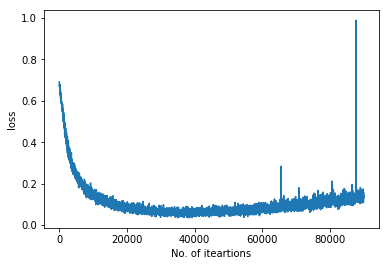

In [13]:
ax = sns.lineplot(batch_ids, losses)
ax.set(xlabel='No. of iteartions', ylabel='loss')
plt.show()